# Exercice WeierStrass ESILV

code par &copy; [Maxence Raballand 2021](https://maxenceraballand.com)

## init

In [1]:
import numpy as np
import math

In [2]:
EPS = np.finfo(float).eps

In [3]:
def readFile(filename, skipFirstLine = True):
    time, temperature = [], []
    file = open(filename, 'r')
    for line in file.readlines()[1 if skipFirstLine else 0:]:
        a, b = line.split(';')
        time.append(float(a))
        temperature.append(float(b))
    return np.array(time), np.array(temperature)

## Methods to fit population

In [4]:
def set_variable_value(n, borne, type):
    if n < borne[0]:
        n = borne[0]
    elif n > borne[1]:
        n = borne[1]
    return type(n)

In [5]:
def initPopulation(population_size = 100, borne_a = [0+EPS, 1-EPS], borne_b = [1, 20], borne_c = [1, 20]):
    """
    Random initialization
    """
    pop = []
    for _ in range(population_size):
        a = set_variable_value(np.random.random(), borne_a, float)
        b = np.random.randint(borne_b[0], high=borne_b[1])
        c = np.random.randint(borne_c[0], high=borne_c[1])
        pop.append([a, b, c])
    return np.array(pop)

In [6]:
def temperatureCalculIndividu(i, a, b, c):
    sum = .0
    ai = 1
    bi = 1
    ipi = i * math.pi
    cint = int(c)
    for n in range(cint + 1):
        sum += ai * math.cos(ipi * bi)
        if n == cint:
            break
        ai *= a
        bi *= b
    return sum

def temperatureCalcul(i, population):
    size = len(population)
    sum, ai, bi = np.zeros(size), np.ones(size), np.ones(size)
    ipi = i * math.pi
    a, b, c = population[:,0], population[:,1], population[:,2]
    cint = int(max(c))
    test = np.ones(size, dtype=bool)
    for n in range(cint + 1):
        temp = ai * np.cos(ipi * bi)
        test = np.logical_and(test, n <= c)
        temp *= test.astype(int)
        sum += temp
        if n == cint:
            break
        ai = ai * a * test.astype(int)
        bi = bi * b * test.astype(int)
    return sum

In [7]:
def fitnessCalculIndividu(a, b, c, time, temperature):
    cost = .0
    for i in range(len(time)):
        cost += abs(temperatureCalculIndividu(time[i], a, b, c) - temperature[i])
    return cost / len(time)

def total_fitness_individu(population, time, temperature):
    fitnessList = []
    for i in population:
        a, b, c = i
        fitnessList.append(fitnessCalculIndividu(a, b, c, time, temperature))
    return np.array(fitnessList)


def total_fitness(population, time, temperature):
    cost = np.zeros(len(population))
    for i in range(len(time)):
        cost += np.absolute(temperatureCalcul(time[i], population) - temperature[i])
    return cost / len(time)

In [8]:
def select_parents(population, fitness, number_of_parents = 20):
    prob = 1/fitness
    prob = prob / sum(prob)
    choices = np.random.choice(population.shape[0], size=number_of_parents*2, replace=False, p=prob)
    parents = []
    for i in range(0, len(choices), 2):
        parents.append([population[choices[i]], population[choices[i + 1]]])
    parents = np.array(parents)
    return parents

In [9]:
def crossover(p1, p2, alpha_a_crossover = .3):
    c1, c2 = np.zeros(3), np.zeros(3)
    c1[1], c2[1] = p1[1], p2[1]
    c1[2], c2[2] = p2[2], p1[2]
    c1[0], c2[0] = p1[0] * alpha_a_crossover + p2[0] * (1 - alpha_a_crossover), p2[0] * alpha_a_crossover + p1[0] * (1 - alpha_a_crossover)
    return c1, c2

In [10]:
def b_c_flip_mutation(childrens, borne_b, borne_c, number_of_bc_flips = 5):
    index = np.random.choice(childrens.shape[0], size=number_of_bc_flips, replace=False)
    for i in index:
        childrens[i][1], childrens[i][2] = set_variable_value(childrens[i][2], borne_b, int), set_variable_value(childrens[i][1], borne_c, int)

def reset_mutation(childrens, borne_a, borne_b, borne_c, number_of_resets = 10):
    rows = np.random.choice(childrens.shape[0], size = number_of_resets, replace=False)
    columns = np.random.choice(childrens.shape[1], size = number_of_resets)
    for i in range(number_of_resets):
        if columns[i] == 0:
            childrens[rows[i]][columns[i]] = set_variable_value(np.random.random(), borne_a, float)  
        elif columns[i] == 1:
             childrens[rows[i]][columns[i]] = np.random.randint(borne_b[0], high=borne_b[1])
        else:
            childrens[rows[i]][columns[i]] = np.random.randint(borne_c[0], high=borne_c[1])

def a_mutation(childrens, borne_a, number_of_a_variations = 10, a_std_mutation = .2):
    variations = np.random.normal(scale=a_std_mutation, size=number_of_a_variations)
    np.random.shuffle(childrens)
    for i in range(number_of_a_variations):
        childrens[i][0] = set_variable_value(childrens[i][0] + variations[i], borne_a, float)

In [11]:
def selection(population, childrens, fitness):
    tokeep = np.where(fitness == min(fitness))
    fitness = np.delete(fitness, tokeep)
    fitness = fitness/sum(fitness)
    change = np.random.choice(np.delete(np.arange(len(population)), tokeep), size=len(childrens), p=fitness, replace=False)
    for i in range(len(childrens)):
        population[change[i]] = childrens[i]

## Single fit and fit loop

Progressbar package is required

```bash
$ conda install progressbar2

or

$ pip install progressbar
```

In [12]:
def single_fit(population, time, temperature, number_of_parents = 20, alpha_a_crossover = .3, number_of_bc_flips = 5, number_of_resets = 10, number_of_a_variations = 10, a_std_mutation = .2, fitness = None, borne_a = [0+EPS, 1-EPS], borne_b = [1, 20], borne_c = [1, 20]):
    # Fitness
    if np.any(fitness):
        fitness = total_fitness(population, time, temperature)
    # Parent selection
    parents = select_parents(population, fitness, number_of_parents)
    # Crossover
    childrens = []
    for couple in parents:
        p1, p2 = couple
        c1, c2 = crossover(p1, p2, alpha_a_crossover)
        childrens.append(c1)
        childrens.append(c2)
    childrens = np.array(childrens)
    # mutation
    if number_of_bc_flips > 0:
        b_c_flip_mutation(childrens, borne_b, borne_c, number_of_bc_flips)
    if number_of_resets > 0:
        reset_mutation(childrens, borne_a, borne_b, borne_c, number_of_resets)
    if number_of_a_variations > 0:
        a_mutation(childrens, borne_a, number_of_a_variations, a_std_mutation)
    # Selection
    selection(population, childrens, fitness)

In [13]:
def stopAfter(after = 50):
    def stop(best_fitness):
        if len(best_fitness) > after and best_fitness[-after] == best_fitness[-1]:
            return True
        return False
    return stop

In [14]:
import progressbar
import time as t
def fit(population, time, temperature, nb_of_cycle = 10, stopFunction = stopAfter(), number_of_parents = 20, alpha_a_crossover = .3, number_of_bc_flips = 5, number_of_resets = 10, number_of_a_variations = 10, a_std_mutation = .2, borne_a = [0+EPS, 1-EPS], borne_b = [1, 20], borne_c = [1, 20]):
    best = []
    best_fitness = []
    start = t.time()
    for i in progressbar.progressbar(range(nb_of_cycle)):
        fitness = total_fitness(population, time, temperature)
        round_best_index = np.where(fitness == min(fitness))[0][0]
        best.append(population[round_best_index])
        best_fitness.append(fitness[round_best_index])
        if stopFunction(best_fitness):
            break
        single_fit(population, time, temperature, number_of_parents, alpha_a_crossover, number_of_bc_flips, number_of_resets, number_of_a_variations, a_std_mutation, fitness, borne_a, borne_b, borne_c)
    duration = t.time() - start
    fitness = total_fitness(population, time, temperature)
    round_best_index = np.where(fitness == min(fitness))[0][0]
    best.append(population[round_best_index])
    best_fitness.append(fitness[round_best_index])
    print("\nbest fitness : %s\nbest individual : %s\ndurations : %s" % (best_fitness[-1], best[-1], duration))
    return best, best_fitness, duration

## Test Section

Graphs with matplotlib

In [15]:
time, temperature = readFile('temperature_sample_calibrate2.csv')

In [16]:
print(time, temperature)

[0.635 1.996 0.812 0.244 1.909 0.813 0.914 1.951 0.156 0.014 1.642 1.96
 0.624 0.893 1.649 1.338 1.116 1.697 0.124 0.992] [-0.287  1.121 -0.897  0.676  1.029 -0.867 -1.012  0.856  0.759  1.075
  0.293  0.888 -0.27  -1.076  0.347 -0.534 -1.061  0.675  0.969 -1.117]


In [17]:
borne_a = [0+EPS, 1-EPS] 
borne_b = [1, 20] 
borne_c = [1, 20]
population = initPopulation(1000)

In [18]:
best, best_fitness, duration = fit(population, time, temperature, nb_of_cycle=10000, stopFunction=stopAfter(500), number_of_parents=30, alpha_a_crossover=.4, number_of_bc_flips=0, number_of_resets=30 , number_of_a_variations=20, a_std_mutation=.3, borne_a = borne_a, borne_b = borne_b, borne_c = borne_c)

 12% (1232 of 10000) |##                 | Elapsed Time: 0:00:40 ETA:   0:04:48
best fitness : 0.006969781298405689
best individual : [ 0.14122475 19.          2.        ]
durations : 40.848551750183105


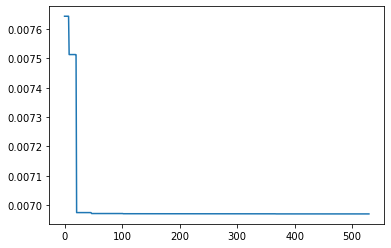

In [19]:
import matplotlib.pyplot as plt

plt.plot(best_fitness[:530])
plt.yscale('linear')

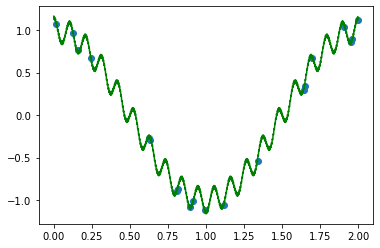

In [20]:
a, b, c = best[-1]
x = np.arange(0, 2, .001)
y = [temperatureCalculIndividu(i, a, b, 2) for i in x]
plt.plot(x, y, color='green')
plt.scatter(time, temperature)

In [21]:
total_fitness(np.array([[.14, 19, 5]]), time, temperature)

array([0.00760009])